In this analysis, our main goal is to predict the total revenue (order_total) generated from customer orders on the Blinkit platform.

We combined multiple datasets (orders, inventory, customer feedback, etc.), performed feature engineering, and trained a machine learning model (XGBoost) to forecast revenue trends.

By creating key features like average revenue per order, price effect, and growth rate, we built a model capable of predicting revenue for the next 30 days, helping the business make better planning and strategy decisions.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
import category_encoders as ce
from datetime import datetime
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [168]:
customer_feedback = pd.read_csv("cleaned_blinkit_feedback.csv")
customer = pd.read_csv("cleaned_blinkit_customer.csv")
inventory = pd.read_csv("cleaned_blinkit_inventory.csv")
order_items = pd.read_csv("cleaned_blinkit_order_items.csv")
orders = pd.read_csv("cleaned_blinkit_orders.csv")

In [169]:
df = orders.copy()

# Rename Target
df.rename(columns={"order_total":"total_sum"}, inplace=True)

# Merge customers & feedback data
df = df.merge(customer[['customer_id', 'customer_segment', 'total_orders']], on='customer_id', how='left')
df = df.merge(customer_feedback[['customer_id', 'sentiment']], on='customer_id', how='left')

In [170]:
df['order_date'] = pd.to_datetime(df['order_date']).dt.date
inventory['date'] = pd.to_datetime(inventory['date'], dayfirst=True).dt.date

# Group inventory by date to prevent duplicate stock entries
inventory_grouped = inventory.groupby('date', as_index=False)['stock_received'].sum()

# Merge inventory data (now grouped) into orders
df = df.merge(inventory_grouped, left_on='order_date', right_on='date', how='left')

# Fill missing stock_received values with 0
df['stock_received'] = df['stock_received'].fillna(0)

C:\Users\VTE\AppData\Local\Temp\ipykernel_2604\3652680578.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  inventory['date'] = pd.to_datetime(inventory['date'], dayfirst=True).dt.date


In [173]:
# Merge order_items data (aggregate per order_id to prevent duplication)
order_items_grouped = order_items.groupby('order_id', as_index=False).agg({'quantity': 'sum', 'unit_price': 'mean'})

# Merge aggregated order items into df
df = df.merge(order_items_grouped, on='order_id', how='left')

In [174]:
# Drop unnecessary columns
df.drop(columns=['order_id', 'customer_id', 'promised_delivery_time', 'actual_delivery_time',
                                  'delivery_status', 'payment_method', 'delivery_partner_id', 'store_id',"date"], inplace=True)

In [ ]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['day_of_week'] = df['order_date'].dt.dayofweek
df['month'] = df['order_date'].dt.month
df['day'] = df['order_date'].dt.day
df.drop(columns=['order_date'], inplace=True)

**Target Encoding for `customer_segment`**

We applied **target encoding** to the `customer_segment` column because it has no inherent order (i.e., it's **nominal**) and we wanted to capture its relationship with the numerical target variable `total_orders`.  
Target encoding replaces each category with the **average number of orders** made by customers in that segment.

This method helps the model learn **how valuable each segment is**, rather than just giving it arbitrary numbers. It’s especially useful when:
- The categories have **no natural order**
- There’s a meaningful **numerical target variable**
- You're aiming to **enhance predictive power** in models

---

**Ordinal Encoding for `sentiment`**

For the `sentiment` column, we used simple **label encoding** via a dictionary:

This works well because `sentiment` is **ordinal** — the categories have a clear, natural order from negative to positive.  
Assigning numerical values in this order allows models to **understand the progression** from bad to good, which reflects real-world meaning.

In [176]:
# sentiment
sentiment_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df.replace(sentiment_mapping,inplace=True)

# encoder_customer_segment
target_encoder=ce.TargetEncoder(cols="customer_segment")
df['customer_segment'] = target_encoder.fit_transform(df['customer_segment'], df['total_orders'])

# EDA

# Temporal Trend of Total Revenue 

 1. The plot shows the overall trend of total revenue (total_sum) over time, using a sequence of days and months as the time axis.

c:\Users\VTE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\VTE\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


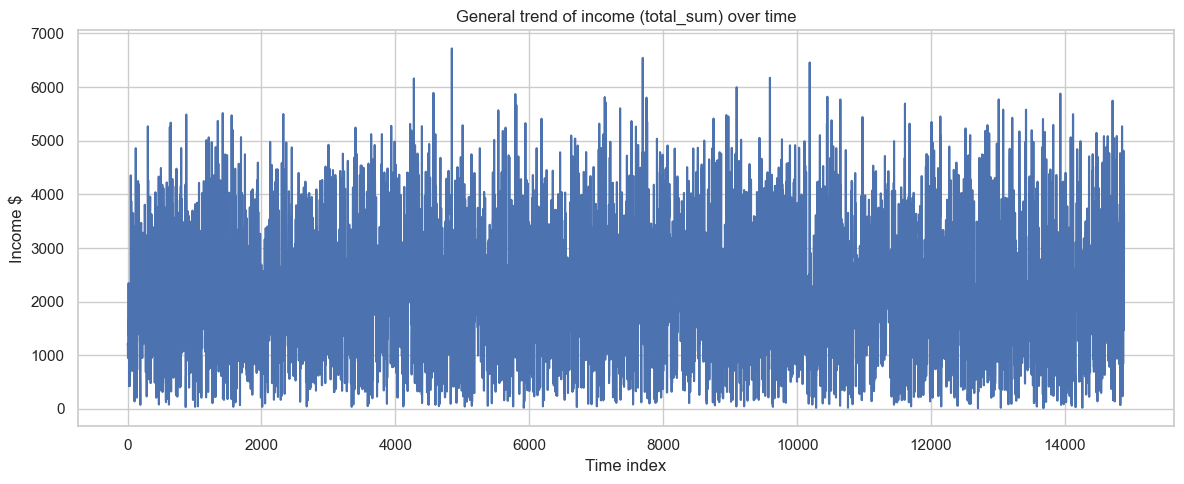

In [177]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df.sort_values(by=["month","day"]), x=range(len(df)),y="total_sum")
# sns.lineplot(data=df.sort_values(by="order_date"), x="order_date", y="total_sum")
plt.title("General trend of income (total_sum) over time")
plt.xlabel("Time index")
plt.ylabel("Income $")
plt.tight_layout()
plt.show()

- There are regular fluctuations throughout the timeline, which is typical for retail or e-commerce sales.  
- Certain spikes in revenue stand out and are likely linked to seasonal events, promotions, or high-demand periods.  
- Overall, despite some noise, the revenue trend appears relatively stable over time without significant long-term increases or declines.

# Sales Distribution by Day of the Week

This boxplot shows the distribution of daily total revenue (total_sum) across each day of the week (day_of_week), where:

0 = Monday

6 = Sunday

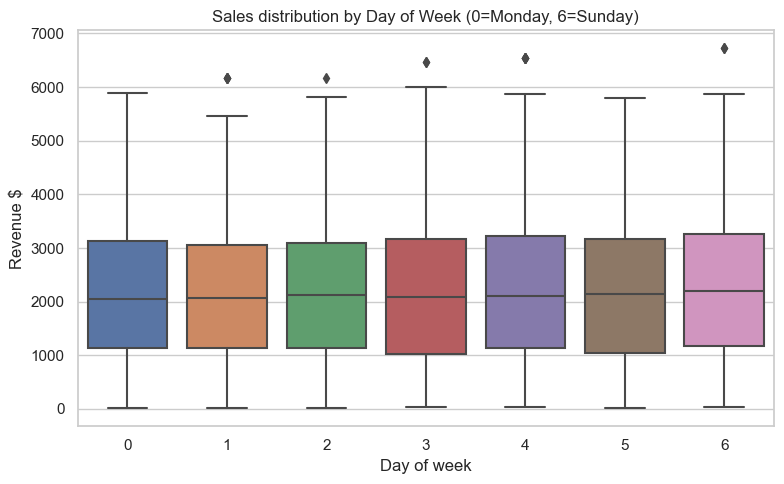

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="day_of_week",y="total_sum")
plt.title("Sales distribution by Day of Week (0=Monday, 6=Sunday)")
plt.xlabel("Day of week")
plt.ylabel("Revenue $")
plt.tight_layout()
plt.show()

#adjust the labels

**Observations**

1. **Consistent distributions across all days:**
   - The median remains almost identical throughout the week.
   - This indicates that sales volume is relatively stable on most days.

2. **Slight increase on certain days:**
   - The boxplots for days 3, 4, and 6 (Thursday, Friday, and Sunday) show a slightly higher median and spread.
   - This suggests there may be more activity towards the end of the week.

3. **Presence of outliers:**
   - Some days show high-value outliers.
   - These outliers indicate occasional spikes in revenue, possibly due to large orders, promotions, or special days.

# Sales Distribution by Month

This boxplot shows the distribution of monthly revenue (total_sum) accross each month (1-12).

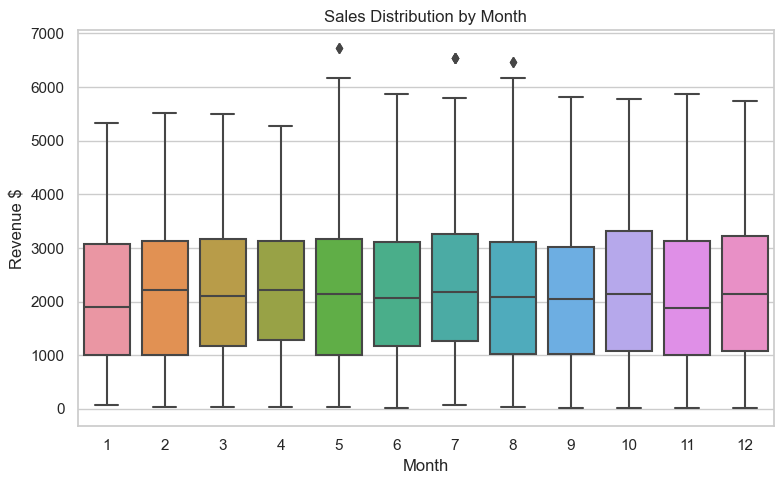

In [179]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="month",y="total_sum")
plt.title("Sales Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Revenue $")
plt.tight_layout()
plt.show()

**Observations:**

1. **Similar medians across months:**
   - The median values (middle line in the boxes) are fairly consistent, indicating that monthly income remains balanced throughout the year.

2. **Slightly higher spreads in months 5, 7, and 12:**
   - These months (May, July, and December) show a wider range of values and more high-value outliers, suggesting potential seasonal boosts in sales.

3. **Outliers in mid and end months:**
   - The spikes in May and July may indicate mid-year promotions or special events.
   - The spikes in December are likely a result of the holiday season, which is common for e-commerce sales performance.

# Relationship Between Stock Received and Total Revenue

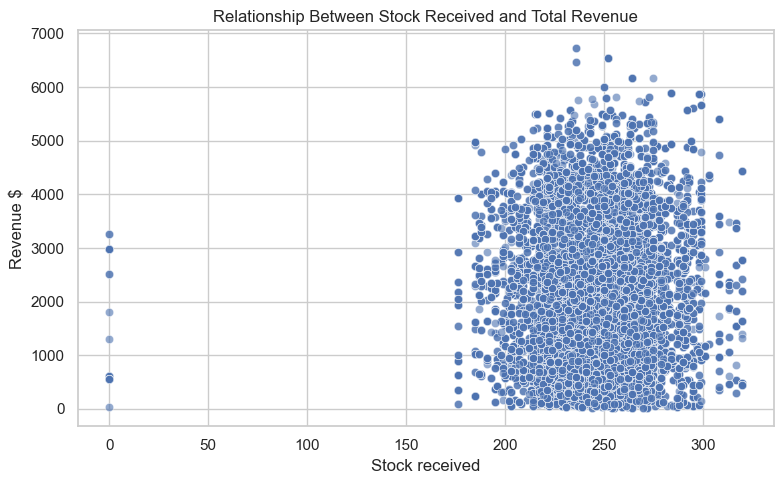

In [181]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df,x="stock_received",y="total_sum",alpha=0.6)
plt.title("Relationship Between Stock Received and Total Revenue")
plt.xlabel("Stock received")
plt.ylabel("Revenue $")
plt.tight_layout()
plt.show()


**Observations:**

1. **Stock levels mostly range between 200 and 300 units:**
   - Most data points are concentrated within this range, indicating it is the typical restocking level for the store.

2. **No clear linear correlation:**
   - Revenue varies significantly even when stock received remains constant.
   - This suggests that factors beyond stock levels — such as demand, pricing strategies, and promotions — strongly influence revenue.

3. **Stock = 0 with revenue > 0:**
   - A few instances show sales occurring despite no new stock received.
   - This likely points to sales from existing inventory or timing differences in stock recording.

In [200]:
df

total_sum  customer_segment  total_orders  sentiment  stock_received  \
7         839.05         10.633146             4          1           222.0   
8         839.05         10.633146             4          2           222.0   
9         839.05         10.633146             4          2           222.0   
10        839.05         10.633146             4          0           222.0   
11        839.05         10.633146             4          2           222.0   
...          ...               ...           ...        ...             ...   
14881    1879.46         10.382478             6          2           293.0   
14882    1879.46         10.382478             6          0           293.0   
14883    1879.46         10.382478             6          2           293.0   
14884    1879.46         10.382478             6          2           293.0   
14885    1879.46         10.382478             6          1           293.0   

       quantity  unit_price  day_of_week  month  day  avg_revenue_per_order  \
7             2      923.84            0      9   23             209.762500   
8             2      923.84            0      9   23             209.762500   
9             2      923.84            0      9   23             209.762500   
10            2      923.84            0      9   23             209.762500   
11            2      923.84            0      9   23             209.762500   
...         ...         ...          ...    ...  ...                    ...   
14881         1      826.21            2      8   23             313.243333   
14882         1      826.21            2      8   23             313.243333   
14883         1      826.21            2      8   23             313.243333   
14884         1      826.21            2      8   23             313.243333   
14885         1      826.21            2      8   23             313.243333   

       revenue_per_unit  rolling_revenue_avg_7  rolling_revenue_std_7  \
7            419.525000            1591.341429            1098.069889   
8            419.525000            1254.481429             859.049903   
9            419.525000             917.621429              73.496842   
10           419.525000             897.978571              73.496842   
11           419.525000             878.335714              67.093130   
...                 ...                    ...                    ...   
14881       1879.459998            2332.132857             589.350919   
14882       1879.459998            2261.768571             612.735891   
14883       1879.459998            2079.070000             476.326541   
14884       1879.459998            1896.371429              21.092257   
14885       1879.459998            1890.734286              19.254508   

       revenue_growth_rate  stock_to_revenue_ratio  expected_revenue  \
7                -0.737557                0.264585           1847.68   
8                -0.737557                0.264585           1847.68   
9                -0.737557                0.264585           1847.68   
10               -0.140802                0.264585           1847.68   
11               -0.140802                0.264585           1847.68   
...                    ...                     ...               ...   
14881            -0.207651                0.155896            826.21   
14882            -0.207651                0.155896            826.21   
14883            -0.404923                0.155896            826.21   
14884            -0.404923                0.155896            826.21   
14885            -0.020564                0.155896            826.21   

       price_effect_gap  
7              -1008.63  
8              -1008.63  
9              -1008.63  
10             -1008.63  
11             -1008.63  
...                 ...  
14881           1053.25  
14882           1053.25  
14883           1053.25  
14884           1053.25  
14885           1053.25  

[14879 rows x 18 columns]

# FEATURE ENGINEERING

To improve model accuracy by adding more useful information, we will implement several **feature engineering** techniques on the data:

1. **Average Revenue per Order**: Measures the average revenue generated for each order placed.

2. **Revenue per Unit**: Shows how much revenue is earned for each individual unit sold.

3. **Revenue Rolling Mean (7 days)**: Smooths short-term fluctuations to reveal longer-term revenue trends.

4. **Revenue Rolling Std (7 days)**: Captures the variability in revenue over a 7-day period, highlighting periods of instability.

5. **Revenue Growth Rate (% change from 7 days ago)**: Compares the current day's revenue to the revenue from the same day in the previous week, showing growth or decline.

6. **Stock-to-Revenue Ratio**: Indicates how much stock is needed to generate a certain amount of revenue, useful for evaluating operational efficiency.

7. **Price Influence (Expected Revenue vs. Actual Revenue)**:
   - **`expected_revenue`**: Calculated as unit price multiplied by quantity sold.
   - **`price_effect_gap`**: The difference between the actual and expected revenue, which helps identify pricing strategies, promotions, or potential anomalies.

Finally, we will remove rows containing NaNs caused by the rolling calculations.

In [ ]:
# Average Revenue per Order
df['avg_revenue_per_order'] = df['total_sum'] / (df['total_orders'] + 1e-9)

# Revenue per Unit
df['revenue_per_unit'] = df['total_sum'] / (df['quantity'] + 1e-9)

# Revenue Rolling Mean (7 days)
df['rolling_revenue_avg_7'] = df['total_sum'].rolling(window=7).mean()

# Revenue Rolling Std (7 days)
df['rolling_revenue_std_7'] = df['total_sum'].rolling(window=7).std()

# Revenue Growth Rate (% change vs 7 days ago)
df['revenue_growth_rate'] = ((df['total_sum'] - df['total_sum'].shift(7)) / (df['total_sum'].shift(7) + 1e-9))

# Stock-to-Revenue Ratio
df['stock_to_revenue_ratio'] = df['stock_received'] / (df['total_sum'] + 1e-9)

# Price Influence (Price × Quantity vs. Actual Revenue)
df['expected_revenue'] = df['unit_price'] * df['quantity']
df['price_effect_gap'] = df['total_sum'] - df['expected_revenue']

# Drop NaN from rolling calculations
df.dropna(inplace=True)

This heatmap reveals that several of the newly engineered features have a clear correlation with the target variable, suggesting they could play a valuable role in enhancing the model’s predictive accuracy.

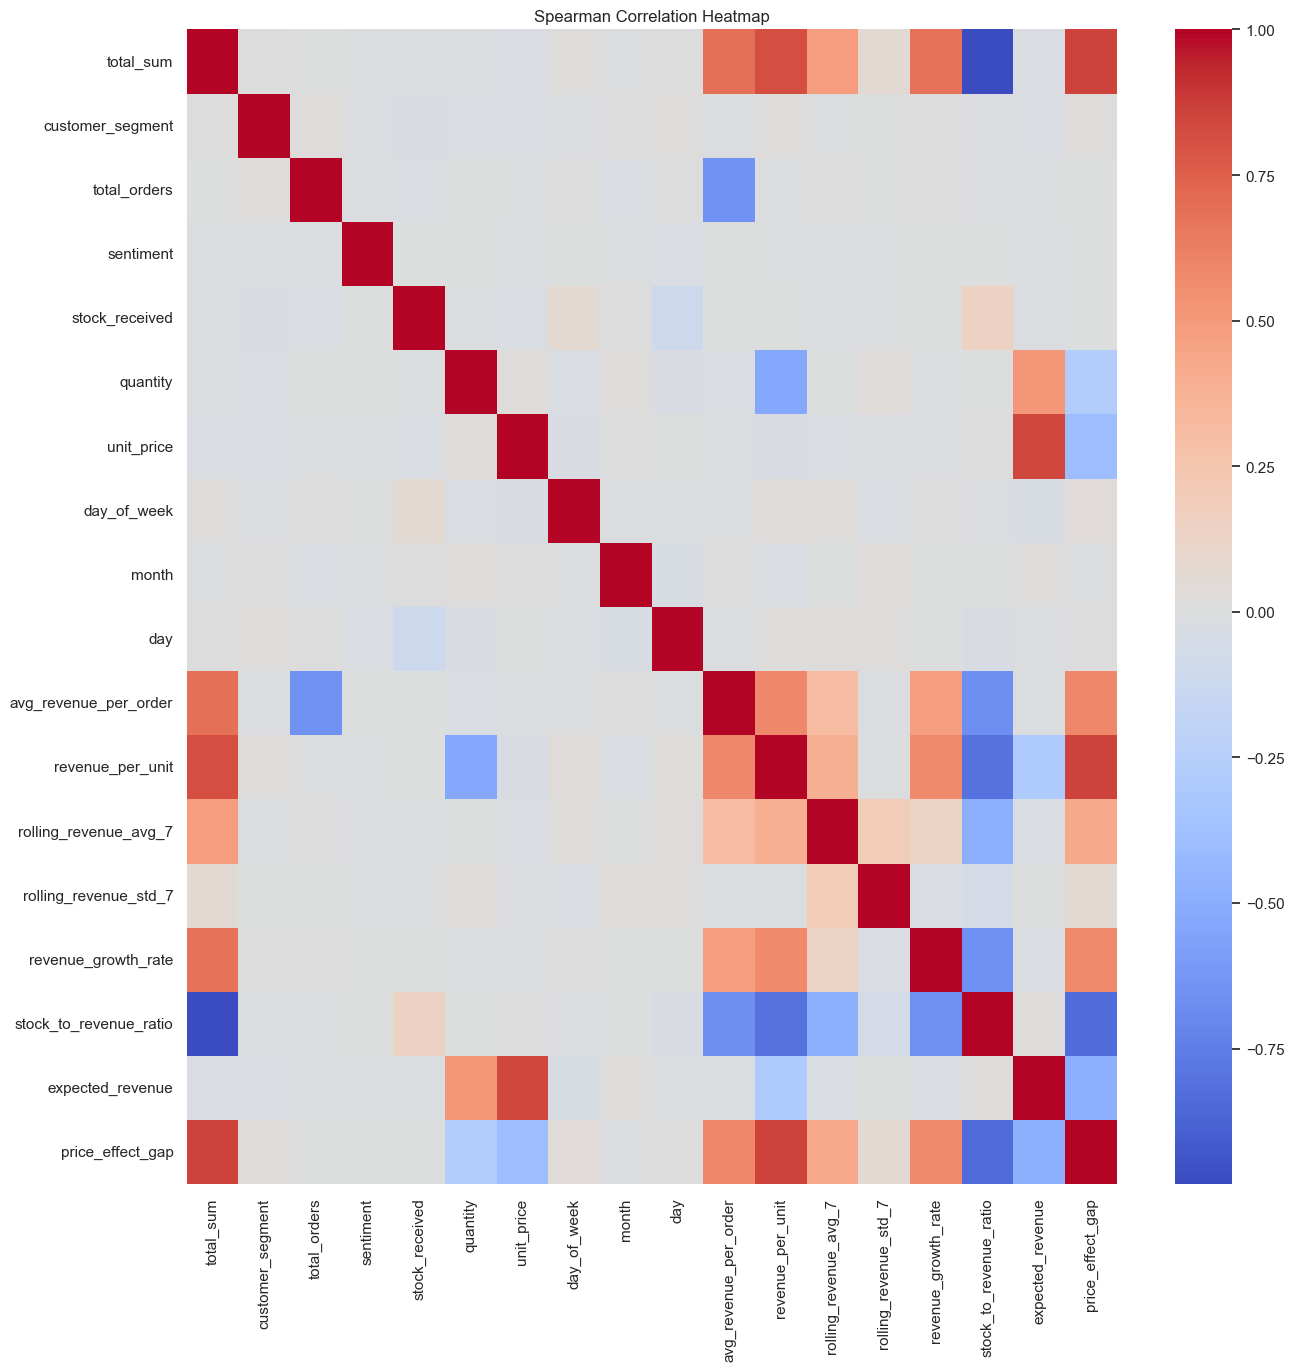

In [205]:
plt.figure(figsize=(15,15))
corr_spearman = df.corr(method='spearman')
sns.heatmap(corr_spearman, annot=False, cmap="coolwarm")
plt.title("Spearman Correlation Heatmap")
plt.show()


Graphs of the new variables vs target

In [1]:
feature_engineered_cols = [
    'avg_revenue_per_order',
    'revenue_per_unit',
    'rolling_revenue_avg_7',
    'revenue_growth_rate',
    'stock_to_revenue_ratio',
    'expected_revenue',
    'price_effect_gap'
]

# Filtering with the target
eda_df = df[feature_engineered_cols + ['total_sum']].copy()

# Graph relationship with total_sum
plt.figure(figsize=(18, 20))
for i, col in enumerate(feature_engineered_cols):
    plt.subplot(4, 2, i+1)
    sns.scatterplot(data=eda_df, x=col, y='total_sum', alpha=0.6)
    plt.title(f"{col} vs Total Sum")
    plt.xlabel(col)
    plt.ylabel("Total Sum")

plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

1. **avg_revenue_per_order vs Total Sum**  
Displays a strong positive correlation — higher order averages tend to align with increased revenue.

2. **revenue_per_unit vs Total Sum**  
Shows a clear upward trend, suggesting it’s a reliable indicator of revenue performance.

3. **rolling_revenue_avg_7 vs Total Sum**  
Presents a moderate positive correlation, reflecting gradual trends in revenue over time.

4. **revenue_growth_rate vs Total Sum**  
Mostly fluctuates around zero, offering little consistent pattern — less useful for prediction.

5. **stock_to_revenue_ratio vs Total Sum**  
Shows an inverse relationship — higher ratios may signal overstocking or operational inefficiencies.

6. **expected_revenue vs Total Sum**  
Lacks a visible pattern — being a theoretical measure, it doesn't align closely with actual results.

7. **price_effect_gap vs Total Sum**  
Reveals a strong positive correlation — variations in pricing effectiveness have a noticeable impact on revenue.

# FORECASTING - PREDICTION WITH XGBOOST

We are going to use the variables with the strongest correlation to the target.

In [ ]:
df2=df.copy()

df2=df[["total_sum","day","month","day_of_week","price_effect_gap","stock_to_revenue_ratio",
                                         "revenue_growth_rate","rolling_revenue_avg_7",
                                         "revenue_per_unit","avg_revenue_per_order"]]

df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14879 entries, 7 to 14885
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_sum               14879 non-null  float64
 1   day                     14879 non-null  int32  
 2   month                   14879 non-null  int32  
 3   day_of_week             14879 non-null  int32  
 4   price_effect_gap        14879 non-null  float64
 5   stock_to_revenue_ratio  14879 non-null  float64
 6   revenue_growth_rate     14879 non-null  float64
 7   rolling_revenue_avg_7   14879 non-null  float64
 8   revenue_per_unit        14879 non-null  float64
 9   avg_revenue_per_order   14879 non-null  float64
dtypes: float64(7), int32(3)
memory usage: 1.1 MB


In [ ]:
X=df2.drop(columns=["total_sum"])
y=df2["total_sum"]

In [187]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


Grid Search in order to optimize the model.

In [188]:
params={
        "n_estimators":[100,200,300],
        "learning_rate":[0.01,0.1,0.3,1],
        "max_depth":[1,2,5]
        }

model=XGBRegressor(objective="reg:squarederror")

grid_search=GridSearchCV(estimator=model, param_grid=params, scoring="neg_mean_absolute_error")

In [189]:
grid_search.fit(X_train,y_train)

best_model= grid_search.best_estimator_

In [190]:
best_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [191]:
y_pred=best_model.predict(X_test)


r2_scor=r2_score(y_test,y_pred)
print("R2 score:",r2_scor)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Display evaluation results
{"Mean Absolute Error (MAE)": mae, "Root Mean Squared Error (RMSE)": rmse}

R2 score: 0.9971040676863705


{'Mean Absolute Error (MAE)': 41.60769746823977,
 'Root Mean Squared Error (RMSE)': 70.3338007904935}

- **R² Score**: The model accounts for roughly 99% of the variability in total revenue, indicating a very strong fit.

- **MAE (Mean Absolute Error)**: On average, the model's predictions differ from the actual revenue by about 41 units.

- **RMSE (Root Mean Squared Error)**: The typical prediction error is around 70 units, with higher emphasis on larger mistakes due to squaring.

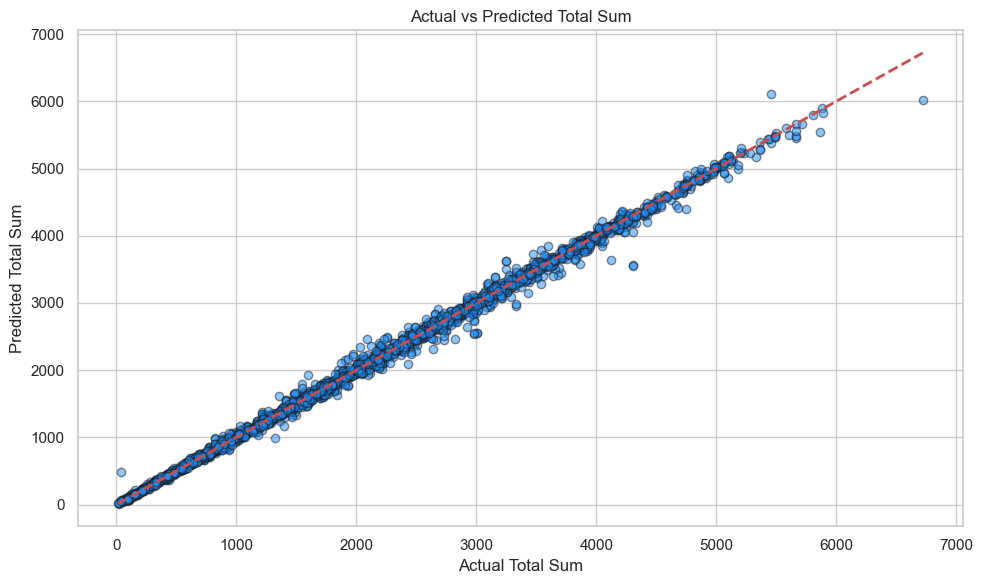

In [192]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='dodgerblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title("Actual vs Predicted Total Sum")
plt.xlabel("Actual Total Sum")
plt.ylabel("Predicted Total Sum")
plt.grid(True)
plt.tight_layout()
plt.show()


This graph shows that the predicted values closely follow the actual values, reflecting the model’s strong accuracy and reliability.

# PREDICTION WITH NEW VALUES

In [193]:
# Generating new date
start_date = datetime.today()
future_dates = pd.date_range(start=start_date, periods=30)

In [194]:
# New DataFrame
future_data = pd.DataFrame({
    'day': future_dates.day,
    'month': future_dates.month,
    'day_of_week': future_dates.dayofweek
})

In [ ]:
# Fill missing columns with the average values from the dataset
columns_to_fill = X.columns.difference(['day', 'month', 'day_of_week'])
for col in columns_to_fill:
    future_data[col] = df2[col].mean()


In [196]:
# Ensure the column order matches the training data
future_data = future_data[X.columns]

In [197]:
# Generate predictions for the future dataset
future_predictions = best_model.predict(future_data)

In [198]:
# Combine date and predicted values into the final DataFrame
future_data['date'] = future_dates
future_data['predicted_total_sum'] = future_predictions

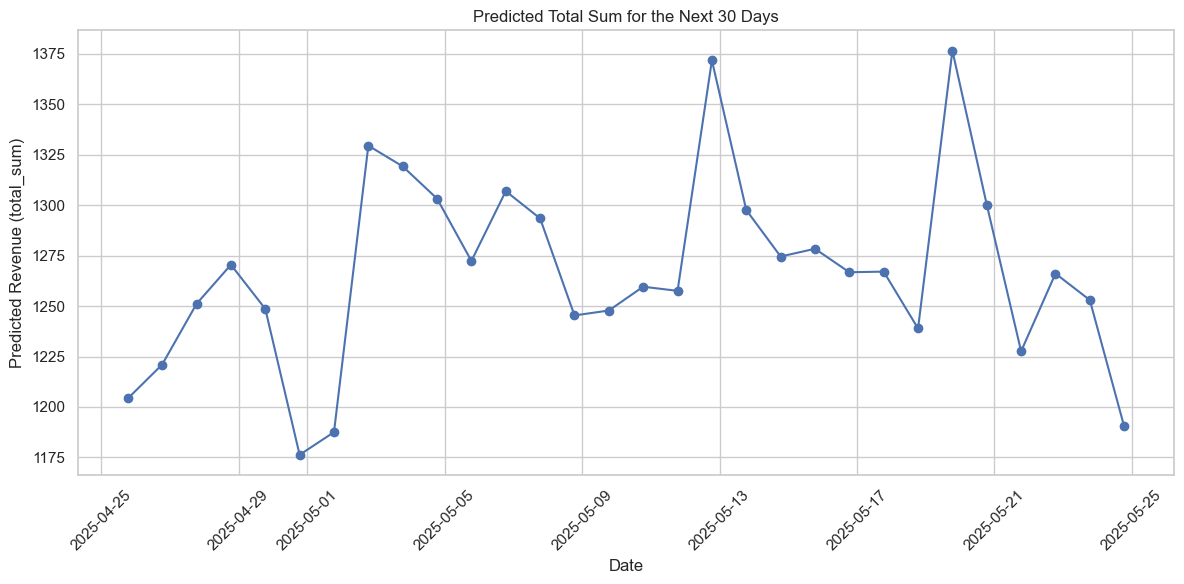

In [199]:
# Plot predicted total sum
plt.figure(figsize=(12, 6))
plt.plot(future_data['date'], future_data['predicted_total_sum'], marker='o', linestyle='-')
plt.title("Predicted Total Sum for the Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Predicted Revenue (total_sum)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Prediction Summary:**  
The line chart illustrates the model's forecast for total revenue over the next 30 days. While there are some day-to-day fluctuations and occasional peaks suggesting potential sales surges, the overall trend remains steady, indicating a consistent and stable revenue pattern for the coming month.